In [1]:
import chebpy as cp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

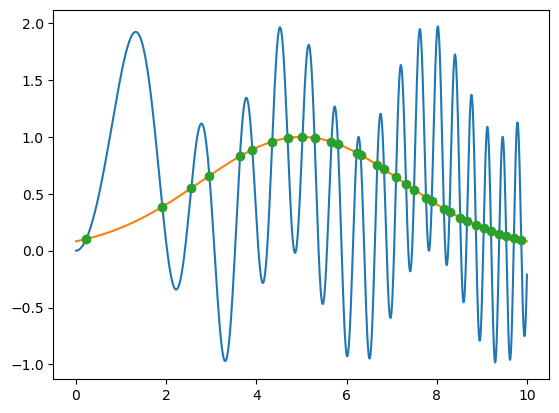

In [3]:
f = cp.chebfun(lambda x: np.sin(x**2) + np.sin(x)**2, [0, 10])
g = cp.chebfun(lambda x: np.exp(-(x-5)**2/10), [0, 10])
r = (f-g).roots()
ax = f.plot(); g.plot()
ax.plot(r, f(r), 'o')

In [4]:
def green(x,s):
    g = 0
    g = (x <= s) * (x * (1-s)) + (x > s) * (s * (1-x))
    return g

In [5]:
x,s = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))

In [6]:
# g = green(x,s)

# plt.figure(figsize = (5,5))
# plt.contourf(x,s, g, 20)

In [36]:
f = lambda x: green(x,s[14][14])

In [55]:
cp.UserPreferences.eps = 1e-10
fc = cp.chebfun(f, [0,1])

In [79]:
vars(cp.core.settings.DefaultPreferences)

mappingproxy({'__module__': 'chebpy.core.settings',
              '__doc__': 'Default preferences for chebpy.',
              'eps': 2.220446049250313e-16,
              'tech': 'Chebtech2',
              'domain': array([-1.,  1.]),
              'N_plot': 2001,
              'maxpow2': 16,
              'maxiter': 10,
              'sortroots': False,
              'mergeroots': True,
              '_defaults': <classmethod(<function DefaultPreferences._defaults at 0x114754430>)>,
              '__dict__': <attribute '__dict__' of 'DefaultPreferences' objects>,
              '__weakref__': <attribute '__weakref__' of 'DefaultPreferences' objects>})

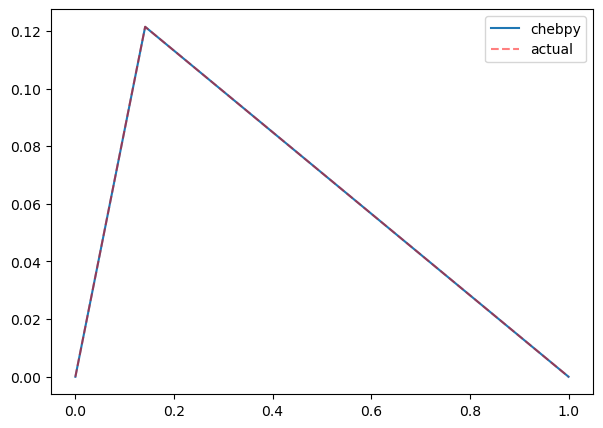

In [56]:
plt.figure(figsize = (7,5))
ax = fc.plot()
ax.plot(x[0],f(x[0]),'r--', alpha = 0.5)
plt.legend(['chebpy','actual'])

In [165]:
def scaleNodes(x, dom):
    # SCALENODES   Scale the Chebyshev nodes X from [-1,1] to DOM.
    if dom[0] == -1 and dom[1] == 1:
        # Nodes are already on [-1, 1]
        return x

    # Scale the nodes:
    return dom[2]*(x + 1)/2 + dom[1]*(1 - x)/2

def chebpts(n, dom = cp.core.settings.DefaultPreferences.domain, type = 2):
    #chebpts    Chebyshev points.
    #   chebpts(N) returns N Chebyshev points of the 2nd-kind in [-1,1].
    #
    #   chebpts(N, D), where D is vector of length 2 and N is a scalar integer,
    #   scales the nodes and weights for the interval [D(1),D(2)].

    ##################################################################################
    #   [Mathematical reference]:
    #   Jarg Waldvogel, "Fast construction of the Fejer and Clenshaw-Curtis
    #   quadrature rules", BIT Numerical Mathematics, 46, (2006), pp 195-202.
    ##################################################################################

    # Create a dummy CHEBTECH of appropriate type to access static methods.
    if type == 1:
        f = cp.core.chebtech.Chebtech
    elif type == 2:
        f = cp.core.chebtech.Chebtech2
    else:
        raise Exception('CHEBFUN:chebpts:type, Unknown point type.') 

    if np.size(n) == 1:         # Single grid
        # Call the static CHEBTECH.CHEBPTS() method:
        x = f._chebpts(n)
        # Scale the domain:
        x = scaleNodes(x, dom)
    else:                  # Piecewise grid.
        raise NotImplementedError
    return x

In [376]:
def points2D(m, n, dom, prefx, prefy):
    # Get the sample points that correspond to the right grid for a particular
    # technology.
    
    if prefy == None:
        prefy = prefx
        
    # What tech am I based on?
    techx, techy = prefx.tech, prefy.tech
    
    # Check if there is a correct version of chebpts with interval support. chebpts2 does not support intervals
    if techx == "Chebtech2":
        x = chebpts(m, dom)
    else:
        raise Exception('CHEBFUN:CHEBFUN2:constructor:points2D:tecType, Unrecognized technology')

    if techy == "Chebtech2":
        y = chebpts(n, dom)
    else:
        raise Exception('CHEBFUN:CHEBFUN2:constructor:points2D:tecType, Unrecognized technology')

    [xx, yy] = np.meshgrid(x,y)
    return xx, yy

In [377]:
def evaluate(op, xx, yy, flag = 0):
    # EVALUATE  Wrap the function handle in a FOR loop if the vectorize flag is
    # turned on.

    if(flag):
        vals = np.zeros((yy.shape[0], xx.shape[1]))
        for jj in range(yy.shape[0]):
            for kk in range(xx.shape[1]):
                vals[jj, kk] = op( xx(0,kk), yy(jj,0))
    else:
        vals = op(xx,yy)  # Matrix of values at cheb2 pts.
    return vals

In [378]:
def getTol(xx, yy, vals, dom, pseudoLevel):
    # GETTOL     Calculate a tolerance for the Chebfun2 constructor.
    #
    #  This is the 2D analogue of the tolerance employed in the chebtech
    #  constructors. It is based on a finite difference approximation to the
    #  gradient, the size of the approximation domain, the internal working
    #  tolerance, and an arbitrary (2/3) exponent.

    m, n = vals.shape
    grid = max(m,n)
    dfdx, dfdy = 0, 0

    if m > 1 and n > 1:
        # Remove some edge values so that df_dx and df_dy have the same size.
        dfdx = np.diff(vals[:m-1,:],1,1) / np.diff(xx[:m-1,:],1,1) # xx diffs column-wise.
        dfdy = np.diff(vals[:,:n-1],1,0) / np.diff(yy[:,:n-1],1,0) # yy diffs row-wise.
    elif m > 1 and n == 1:
        # Constant in x-direction
        dfdy = np.diff(vals,1,1) / np.diff(yy,1,1);
    elif m == 1 and n > 1:
        # Constant in y-direction
        dfdx = np.diff(vals,1,2) / np.diff(xx,1,2)

    # An approximation for the norm of the gradient over the whole domain.
    Jac_norm = max(np.max(np.abs(dfdx[:])), np.max(np.abs(dfdy[:])))
    vscale = np.max(np.abs(vals[:]))
    relTol = grid**(2/3) * pseudoLevel # This should be vscale and hscale invariant
    absTol = np.max(np.abs(dom[:])) * max(Jac_norm, vscale) * relTol

    return relTol, absTol

In [379]:
def Max(A):
    return np.max(A), np.argmax(A)

In [380]:
def completeACA(A, absTol, factor):
    # Adaptive Cross Approximation with complete pivoting. This command is
    # the continuous analogue of Gaussian elimination with complete pivoting.
    # Here, we attempt to adaptively find the numerical rank of the function.

    # Set up output variables.
    nx, ny = A.shape
    width = min(nx, ny)        # Use to tell us how many pivots we can take.
    pivotValue = np.empty(int(np.ceil(width/factor)))         # Store an unknown number of Pivot values.
    pivotElement = np.empty((int(np.ceil(width/factor)),2)) # Store (j,k) entries of pivot location.
    pivotValue[:], pivotElement[:] = np.nan, np.nan
    ifail = 1                  # Assume we fail.

    # Main algorithm
    zRows = 0                  # count number of zero cols/rows.
    infNorm, ind = Max(np.abs(A))
    
    # Check here for errors bc python's default between row and column major is different.
    row, col = np.unravel_index(ind, A.shape) 
    # Error possiblity

    # Bias toward diagonal for square matrices (see reasoning below):
    if (nx == ny) and (np.max(np.abs(np.diag(A))) - infNorm) > -absTol:
        infNorm, ind = Max(np.abs(np.diag(A)))
        row = ind
        col = ind

    scl = infNorm

    # The function is the zero function.
    if scl == 0:
        # Let's pass back the zero matrix that is the same size as A. 
        # This ensures that chebpy2(np.zeros(5)) has a 5x5 (zero) coefficient 
        # matrix.  
        pivotValue = 0
        rows = np.zeros((1, A.shape[1]))
        cols = np.zeros((A.shape[0], 1))
        ifail = 0
    else:
        rows = np.zeros((1, A.shape[1]))
        cols = np.zeros((A.shape[0], 1))
    
    while (infNorm > absTol) and (zRows < width/factor) and (zRows < min(nx,ny)):
        # Check if zRows+1 is correct here
        if zRows == 0:
            rows = A[row,:].reshape((1,-1))
            cols = A[:,col].reshape((-1,1))
        else:
            rows = np.vstack([rows,A[row,:].reshape((1,-1))])
            cols = np.hstack([cols,A[:,col].reshape((-1,1))])            # Extract the columns.
        PivVal = A[row,col]
        A = A - cols[:,zRows].reshape(-1,1) @ (rows[zRows,:].reshape(1,-1)/PivVal) # One step of GE.

        # Keep track of progress.
        pivotValue[zRows] = PivVal                 #pivotValue[zRows] = PivVal             # Store pivot value.
        pivotElement[zRows,:] = [row, col]   #pivotElement[zRows,:]=[row col]        # Store pivot location.
        zRows = zRows + 1                         # One more row is zero.

        # Next pivot.
        infNorm , ind = Max(np.abs(A)) # Slightly faster.
        row , col = np.unravel_index(ind, A.shape) # Check for col/row major

        # Have a bias towards the diagonal of A, so that it can be used as a test
        # for nonnegative definite functions. (Complete GE and Cholesky are the
        # same as nonnegative definite functions have an absolute maximum on the
        # diagonal, except there is the possibility of a tie with an off-diagonal
        # absolute maximum. Bias toward diagonal maxima to prevent this.)
        if (nx == ny) and ((np.max(np.abs(np.diag(A))) - infNorm) > -absTol):
            infNorm, ind = Max(np.abs(np.diag(A)))
            row = ind
            col = ind
    
    # print(infNorm)
    
    if infNorm <= absTol:
        ifail = 0                               # We didn't fail.

    if zRows >= (width/factor):
        ifail = 1                               # We did fail.
    
    return pivotValue, pivotElement, rows, cols, ifail

In [381]:
dom = [0,0,1,1]
minSample = np.array([17,17])
prefx, prefy = cp.core.settings.DefaultPreferences, cp.core.settings.DefaultPreferences
pseudoLevel = min(prefx.eps, prefy.eps)
factor = 4.0

minSample = np.power(2,np.floor(np.log2(minSample-1)))+1
grid = minSample
xx, yy = points2D(grid[0],grid[1],dom,prefx,prefy)

vals = evaluate(green, xx, yy)
vscale = np.max(np.abs(vals[:]))
relTol, absTol = getTol(xx, yy, vals, dom, pseudoLevel)

In [382]:
pivotVal, pivotPos, rowVals, colVals, iFail = completeACA(vals, absTol, factor);